In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [2]:
train_df = pd.read_csv("../dataset/train.csv", index_col="PassengerId")

# Split inputs/targets
y_train = train_df["Survived"] # This is our output
X_train_raw = train_df.drop(columns=["Survived"]) # This is our input

In [3]:
y_train

PassengerId
1      0
2      1
3      1
4      1
5      0
      ..
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

In [4]:
X_train_raw

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...
887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S



In the previous chapter we did our data analysis to understand what transformations we had to apply to our data.

Now we will create a pipeline to apply all those transformations. For that purpose, sklearn has some functions


- FunctionTransformer → “Run my custom function inside sklearn”
- SimpleImputer → “Fix missing values”
- StandardScaler → “Normalize numeric features”
- OneHotEncoder → “Convert categories into binary columns”
- ColumnTransformer → “Apply different logic per column type”
- Pipeline → “Apply a sequence of transforms”


In [5]:
drop_cols = ["Name", "Ticket", "Cabin"]
numeric_cols = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
categorical_cols = ["Sex", "Embarked"]

def drop_unneeded_cols_df(df: pd.DataFrame) -> pd.DataFrame:
    """Drops columns that we are not going to use."""
    return df.drop(columns=drop_cols, errors="ignore")

def log1p_fare_df(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["Fare"] = np.log1p(df["Fare"])
    return df

log_fare = FunctionTransformer(log1p_fare_df, validate=False)

numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocess = Pipeline(steps=[
    # Replaced the lambda with our new named function
    ("drop", FunctionTransformer(drop_unneeded_cols_df, validate=False)),
    ("log_fare", log_fare),
    ("columns", ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, numeric_cols),
            ("cat", categorical_pipe, categorical_cols),
        ],
        remainder="drop"
    )),
])

We almost have our data ready. The only thing left is splitting it into train, test and validation sets and converting it into tensors.

![title](../images/data_split.png)

![title](../images/data_split_training.png)


In our case, to simplify the process we will just use train and validation sets (we will not use a test set).

For this we can use another sklearn function.

In [6]:
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X_train_raw,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train, # Preserve the class proportions when splitting. Without stratify we might get 90% non-survivors and 10% survivors split
)

And now we apply our pipeline

In [7]:
X_train = preprocess.fit_transform(X_train_raw) # We only use fit_transform in our training set. So the 'normalization model' will use mean and std deviation of columns from the training set.
X_val  = preprocess.transform(X_val_raw)

Finally, let's convert to tensors and we are done with the data part.

Although our data is ready, machine learning frameworks usually work with tensors.

![title](../images/tensor.png)

In [8]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.to_numpy(), dtype=torch.float32).view(-1, 1) #view converts from (N,) → (N, 1)

X_val_t   = torch.tensor(X_val, dtype=torch.float32)
y_val_t   = torch.tensor(y_val.to_numpy(), dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=256, shuffle=False)
# batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need. Also weights are updated only after a batch is processed

Now is time to create our neural network. So... what is a neural network?

Formal definition: `An artificial neural network is an interconnected group of nodes, inspired by a simplification of neurons in a brain.`

![title](../images/neural_network.png)

![title](../images/weights.png)

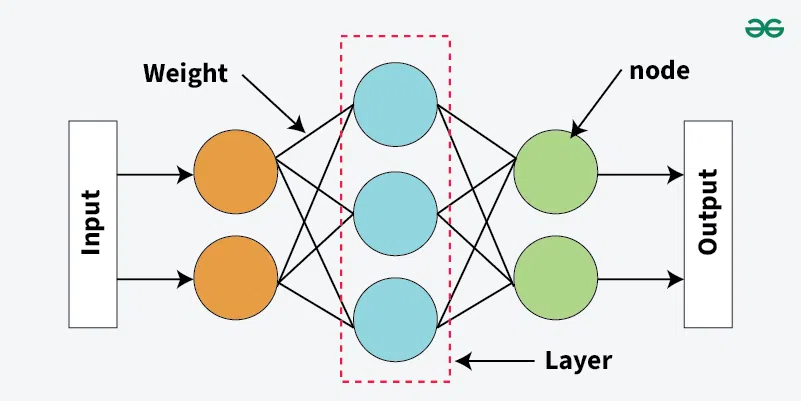

In [9]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_layers=1, dropout=0.1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, int(hidden_size))
        self.fc3 = nn.Linear(int(hidden_size), 1)
        self.dropout = nn.Dropout(dropout)
        self.hidden_size = hidden_size
        self.num_layers = num_layers

    def forward(self, x):
        x = torch.relu(self.fc1(x)) # We are using ReLu activation function. Without an activation function, our model would be linear. As you can see, ReLU does not allow negative values
        x = self.dropout(x)
        for _ in range(1, self.num_layers):
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)
        x = self.fc3(x)
        return x

Activation functions

The Goal: Make decisions and introduce non-linearity.

The Rule: Without them, a neural network can only draw straight lines.

Example (ReLU): Acts like an "IF" gate.

If number < 0 $\rightarrow$ Output 0

Else $\rightarrow$ Let it pass

![title](../images/activation.png)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleNN(input_size=X_train.shape[1], hidden_size=16, num_layers=2, dropout=0.1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

So we defined our model, we are able to update the neurons in a non-linear way with our activation function.

But we are missing something else...

How will the model know how correct/wrong it is?

## Loss function

`loss_fn = nn.BCEWithLogitsLoss()`

**Role**: Calculates exactly how wrong the model is.

**Goal**: Get this number as close to zero as possible.

**BCE**: "Binary Cross Entropy" (Perfect for Yes/No, 1/0 problems).

## Optimizer

With the loss function we know how wrong the model is, but how much should we change each value?

**Role**: Tweaks the model's weights to improve the next guess.

**Adam**: A smart, modern algorithm that adjusts itself.

**lr (Learning Rate)**: The step size (how drastically it changes the weights).

## Backpropagation

With all these ingredients, we can train our model. The algorithm that uses these ingredients is backpropagation algorithm.

![title](../images/backpropagation.png)

In [11]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    """Trains the model for one epoch."""
    model.train() # Set model to training mode (enables dropout, batchnorm, etc.)
    total_loss, correct, total = 0.0, 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device) # PyTorch requires you to move tensors to your device (gpu, cpu)

        # 1. Forward Pass: make predictions
        logits = model(inputs)
        loss = loss_fn(logits, labels)

        # 2. Backward Pass: calculate gradients and update weights
        optimizer.zero_grad() # Clear old gradients
        loss.backward()       # Calculate new gradients
        optimizer.step()      # Update the model's weights

        # 3. Track Metrics
        total_loss += loss.item() * inputs.size(0)

        # Calculate accuracy (Assuming Binary Classification)
        probs = torch.sigmoid(logits) # This is another activation function
        preds = (probs >= 0.5).float()
        correct += (preds == labels).sum().item()
        total += inputs.size(0)

    # Return average loss and accuracy
    return total_loss / total, correct / total

In [12]:
def evaluate_epoch(model, dataloader, loss_fn, device):
    """Evaluates the model on the validation or test set."""
    model.eval() # Set model to evaluation mode
    total_loss, correct, total = 0.0, 0, 0

    # Disable gradient calculation for speed and memory efficiency
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 1. Forward Pass: make predictions
            logits = model(inputs)
            loss = loss_fn(logits, labels)

            # 2. Track Metrics
            total_loss += loss.item() * inputs.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            correct += (preds == labels).sum().item()
            total += inputs.size(0)

    return total_loss / total, correct / total

In [13]:
# Create empty lists to store our metrics over time
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []

best_val_acc = -1.0
best_model_state = None
num_epochs = 50

for epoch in range(1, num_epochs + 1):

    # Train and evaluate for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc     = evaluate_epoch(model, val_loader, loss_fn, device)

    # Save the metrics to our history lists
    history_train_loss.append(train_loss)
    history_val_loss.append(val_loss)
    history_train_acc.append(train_acc)
    history_val_acc.append(val_acc)

    # Save the model if it's the best one we've seen so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())

    # Print progress
    print(f"Epoch {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

# Restore the best model weights at the end of training
model.load_state_dict(best_model_state)
print(f"Training complete. Best Validation Accuracy: {best_val_acc:.4f}")

Epoch 01 | Train Loss: 0.6857 Acc: 0.6166 | Val Loss: 0.6764 Acc: 0.6983
Epoch 02 | Train Loss: 0.6694 Acc: 0.6840 | Val Loss: 0.6624 Acc: 0.6257
Epoch 03 | Train Loss: 0.6551 Acc: 0.6573 | Val Loss: 0.6495 Acc: 0.6257
Epoch 04 | Train Loss: 0.6435 Acc: 0.6573 | Val Loss: 0.6370 Acc: 0.6257
Epoch 05 | Train Loss: 0.6281 Acc: 0.6896 | Val Loss: 0.6251 Acc: 0.6369
Epoch 06 | Train Loss: 0.6139 Acc: 0.6980 | Val Loss: 0.6119 Acc: 0.6816
Epoch 07 | Train Loss: 0.6043 Acc: 0.7037 | Val Loss: 0.5970 Acc: 0.6927
Epoch 08 | Train Loss: 0.5835 Acc: 0.7247 | Val Loss: 0.5803 Acc: 0.7095
Epoch 09 | Train Loss: 0.5652 Acc: 0.7500 | Val Loss: 0.5637 Acc: 0.7318
Epoch 10 | Train Loss: 0.5431 Acc: 0.7598 | Val Loss: 0.5481 Acc: 0.7486
Epoch 11 | Train Loss: 0.5250 Acc: 0.7781 | Val Loss: 0.5320 Acc: 0.7598
Epoch 12 | Train Loss: 0.5054 Acc: 0.7907 | Val Loss: 0.5165 Acc: 0.7654
Epoch 13 | Train Loss: 0.4926 Acc: 0.8020 | Val Loss: 0.5009 Acc: 0.7877
Epoch 14 | Train Loss: 0.4830 Acc: 0.8076 | Val Los

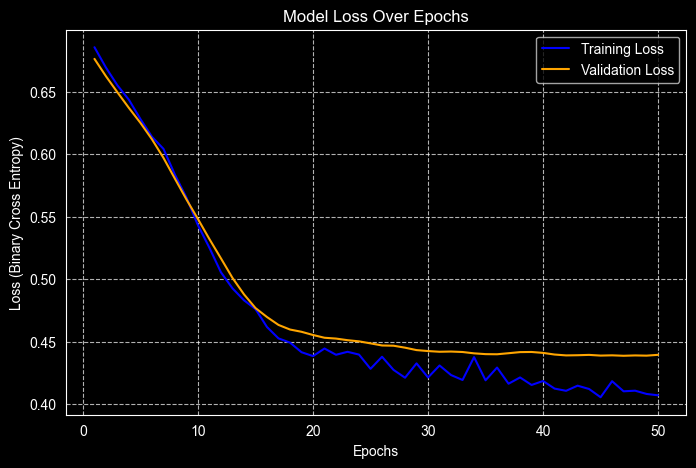

In [14]:
# Plotting the Loss Curves
plt.figure(figsize=(8, 5)) # Set the size of the graphic
plt.plot(range(1, num_epochs + 1), history_train_loss, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), history_val_loss, label='Validation Loss', color='orange')

# Add labels and title
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (Binary Cross Entropy)')

# Add a legend to tell the lines apart and a grid for readability
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

If the training loss keeps going down but the validation loss starts going back up, that is the classic visual definition of overfitting

![title](../images/fitting.png)
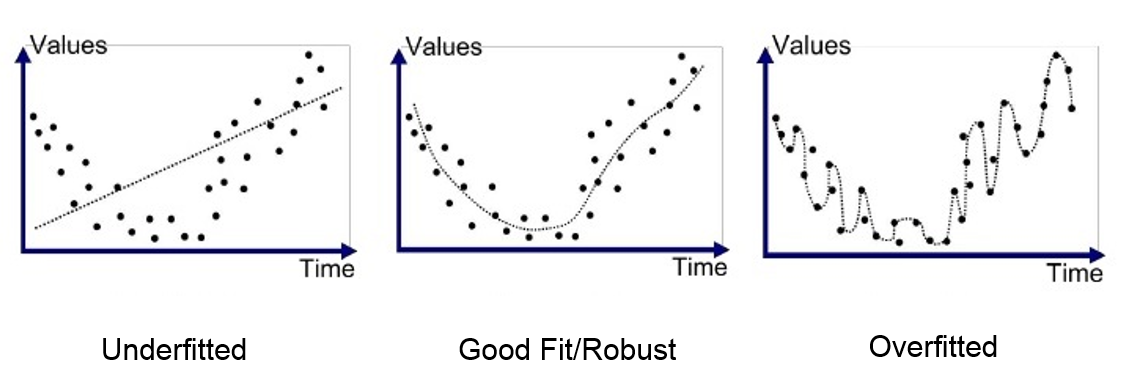

So we successfully trained our model. Now let's save it and we will have some fun with it in the next chapter!

In [15]:
# Save the PyTorch model weights (like we did before)
torch.save(best_model_state, "../models/titanic_best_model.pth")

# Save the scikit-learn preprocessing pipeline
joblib.dump(preprocess, "../models/titanic_preprocessor.joblib") #It's important to save the preprocessor also (our pipeline info). Otherwise we would need to repeat the process every time

print("Both model and preprocessor saved successfully!")

Both model and preprocessor saved successfully!


Just like PyTorch learned the "weights" for your neural network, your scikit-learn preprocess pipeline learned the "rules" for your data during the fit_transform step.

It memorized the exact median age of the training set.

It memorized the exact mean and standard deviation for the scaler.

It memorized the exact column names for the One-Hot Encoder.